# Logistic regression model for predicting high glucose events from food intake data

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

In [160]:
# Import help functions for pulling in data
import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [161]:
from data_processing.cgm_data import CGMData
from data_processing.derived_datasets import max_glucose_dataset

In [162]:
data = CGMData()

## Data import and pre-processing

We are interested here in which food intake events lead to high glucose levels. First, we need to create a dataset from the various csv files we have for different patients and different types of data.

In [314]:
## There are 16 patients in the dataset. 

## We would like two kinds of generlazing from our model: (1) to unseen food intake events for 
## the patients that are part of the training set, and (2) to patients whose data is not part
## of the training set.

## We will use the first 13 patients for training our model and reserve 3 for testing the 
## generalizability of the model to new patients.
participant_numbers = 13

In [324]:
## A high glucose level for someone with diabetes is considered to be "greater than 180 mg/dL
## one to two hours after eating" <https://my.clevelandclinic.org/health/diseases/9815-hyperglycemia-high-blood-sugar>.
## The patients in our dataset have prediabetes and have variable levels of blood glucose 
## control, as shown here.

## Find 5th/95th percentile for glucose range for each patient
## 95th percentile arbitrarily set as a threshold; setting the threshold at other percentiles may yield better results.
## (Setting at the 90th percentile, for example, makes the models below perform differently.)
high_glu = []
low_glu = []
for i in range(1,participant_numbers+1):
    low_glu.append(np.percentile(data[i].glu, 5))
    high_glu.append(np.percentile(data[i].glu, 95))

print(high_glu)
print(low_glu)

[137.0, 167.0, 140.0, 145.0, 129.0, 188.0, 128.0, 143.8499999999999, 177.0, 178.0, 166.0, 164.6500000000001, 168.0]
[85.0, 99.0, 85.0, 85.0, 83.0, 93.0, 70.0, 83.0, 97.2, 81.0, 87.0, 99.0, 97.85000000000001]


In [325]:
df = pd.DataFrame()

for pn in range(1,participant_numbers+1):
    # Select participant number
    participant_number = pn
    high_glu_par = high_glu[participant_number-1]

    # Max glucose between meals:
    df_sub = max_glucose_dataset(cgm_data=data,participant_num=participant_number,glu_thresh=high_glu_par)
    df = pd.concat([df, pd.DataFrame(df_sub)])

# Remove food intake entries for which there is no corresponding glucose data
df = df.dropna(subset=['max_glucose'])

# Remove food intake entries with erroneous carb values
# using a cutoff of 400 grams
df = df[df['total_carb'] <= 400]
df = df[df['total_fat'] <= 200]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 0 to 5
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calorie        230 non-null    float64
 1   total_carb     230 non-null    float64
 2   dietary_fiber  230 non-null    float64
 3   sugar          230 non-null    float64
 4   protein        230 non-null    float64
 5   total_fat      230 non-null    float64
 6   gi             230 non-null    float64
 7   gl             230 non-null    float64
 8   recent_meals   230 non-null    float64
 9   participant    230 non-null    int64  
 10  max_glucose    230 non-null    float64
 11  start_glucose  230 non-null    float64
 12  diff_glucose   230 non-null    float64
 13  mean_temp      192 non-null    float64
 14  mean_hr        193 non-null    float64
 15  mean_acc       192 non-null    float64
 16  mean_eda       192 non-null    float64
 17  high_glucose   230 non-null    bool   
dtypes: bool(1), float

In [326]:
## View the first few rows of the dataset.
df.head()

,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl,recent_meals,participant,max_glucose,start_glucose,diff_glucose,mean_temp,mean_hr,mean_acc,mean_eda,high_glucose
0,456.0,85.0,1.7,83.0,16.0,3.3,33.0,28.050,1.0,1,143.0,59.0,84.0,33.605343,76.982429,0.924898,0.478566,True
1,488.0,2.5,1.2,0.8,63.4,23.1,28.0,0.700,1.0,1,106.0,104.0,2.0,34.328719,68.960515,0.661794,2.321904,False
2,230.0,35.0,0.0,18.0,13.0,0.0,56.5,24.620,1.0,1,122.0,92.0,30.0,33.882256,77.987660,0.791241,0.568190,False
3,280.0,30.0,0.0,22.0,4.0,0.0,62.0,18.600,1.0,1,110.0,89.0,21.0,31.511428,87.463506,0.964078,0.483317,False
4,358.0,14.4,0.0,8.7,13.9,0.0,28.0,4.032,1.0,1,124.0,105.0,19.0,30.470737,75.821212,0.461761,0.209723,False


## Train-test split

In [327]:
# Features for regression
## input variables
X = df[['total_carb','sugar','protein','total_fat','gi','start_glucose']]

## output
y = df[['high_glucose']]

In [328]:
# Split testing and training data

## This will allow us to assess the generalizability to unseen food intake events for the patients 
## that are part of the training set. Note that we have also reserved all data from Patients 14-16 
## to test the generalizability to unseen patients.

## Train-test split stratified on high glucose event, so the small number of high glucose events
## are evenly distributed between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=435,
                                                       test_size=.2,
                                                       stratify=y)

df_train = pd.concat([X_train, y_train], axis=1)

## Feature selection

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

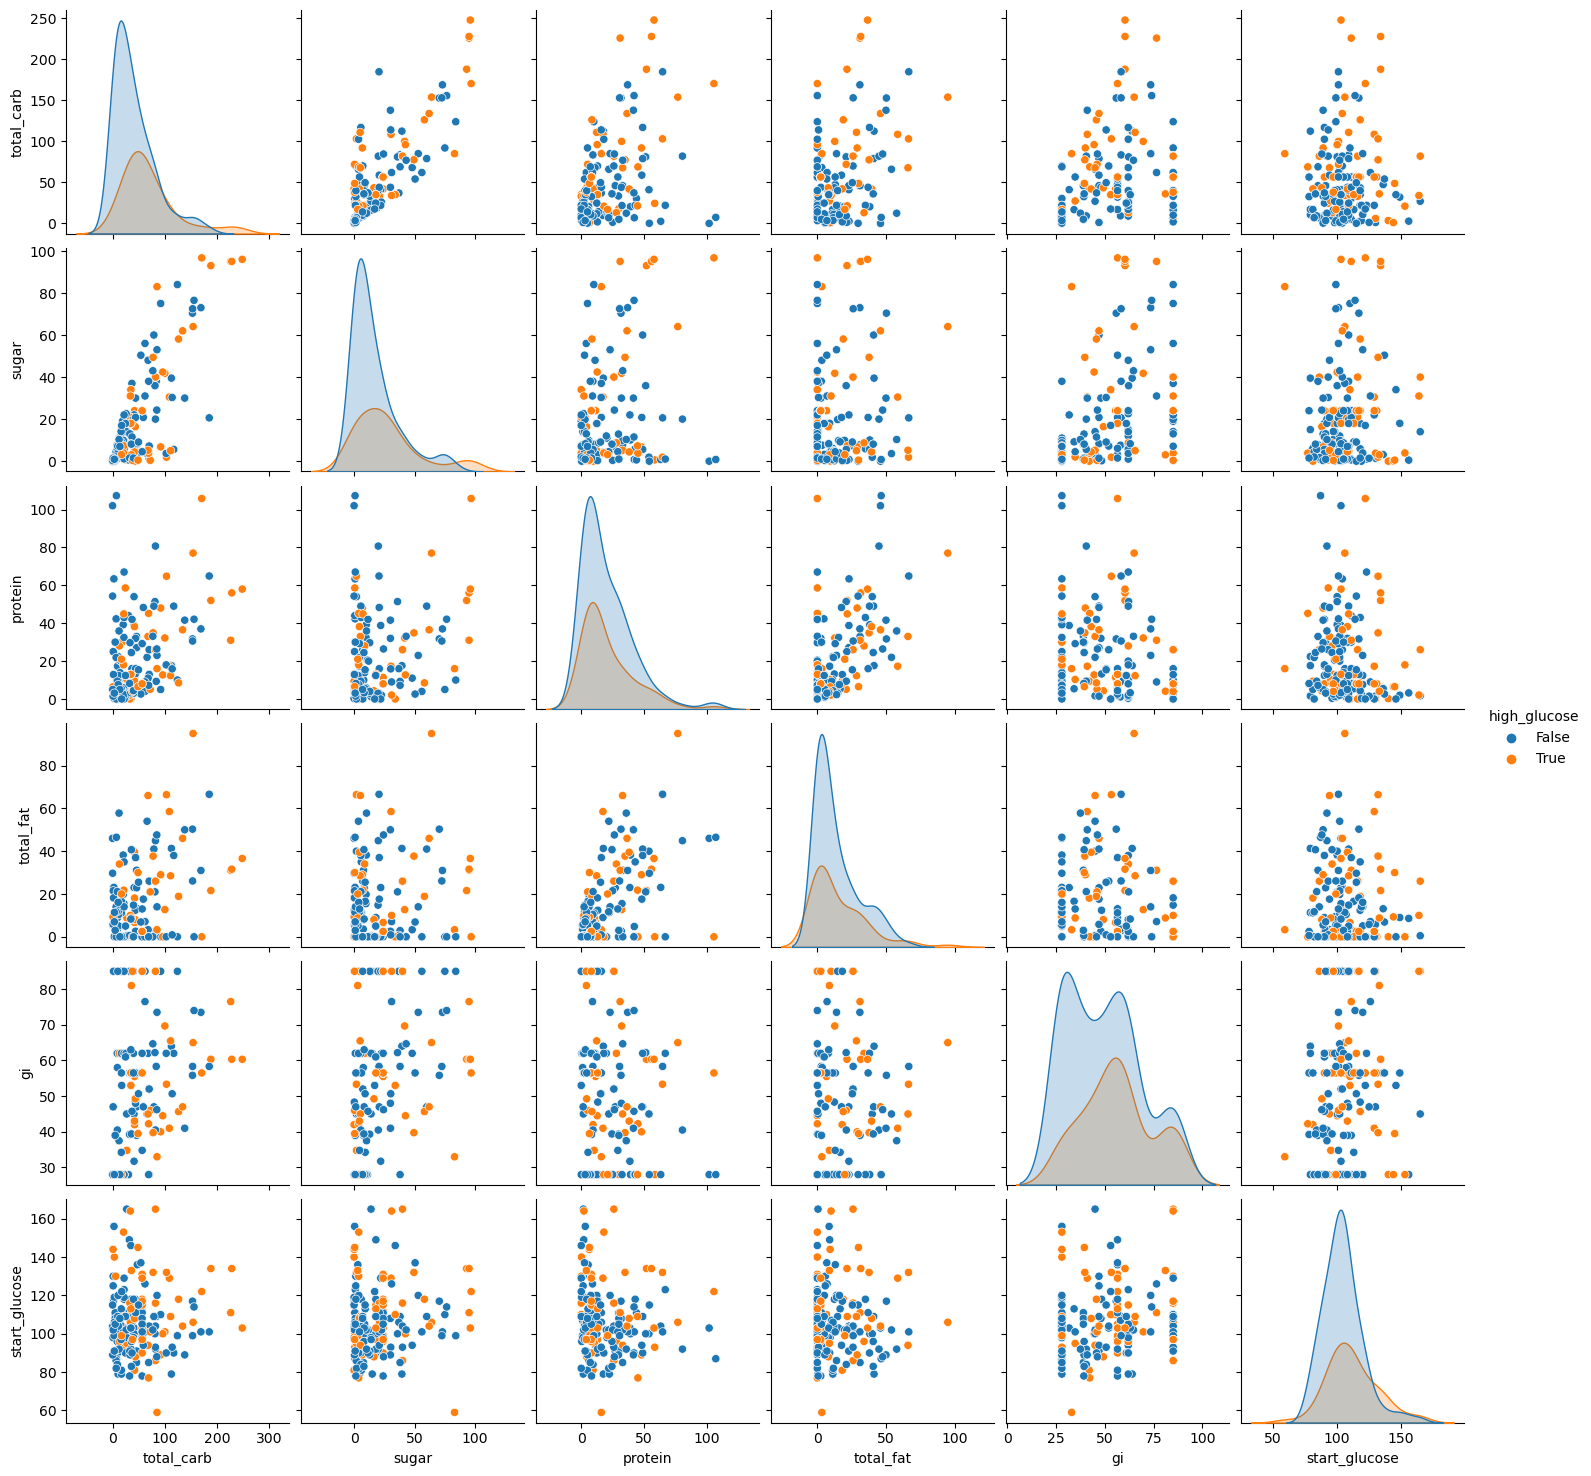

In [329]:
sns.pairplot(data = df_train,
                hue=df_train.columns[-1])

plt.show()

There does not appear to be great separation of high glucose events in any two variables. Below, we investigate some logistic regression models with different numbers of input variables.

## Model 0: predict high glucose by total carbs

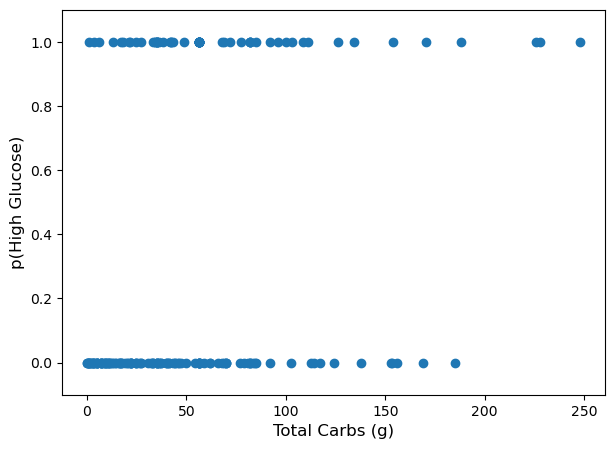

In [330]:
# Plot the training data

plt.figure(figsize = (7,5))

plt.scatter(X_train['total_carb'],y_train)
plt.ylim((-.1,1.1))
plt.xlabel("Total Carbs (g)",fontsize = 12)
plt.ylabel("p(High Glucose)",fontsize = 12)

plt.show()

In [331]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train['total_carb'].values.reshape(-1,1),
            y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty=None)

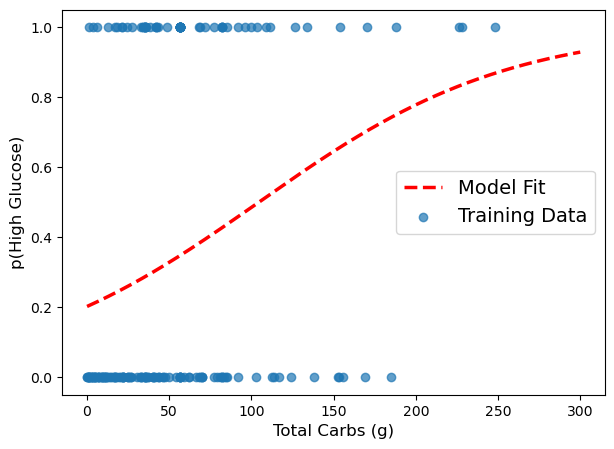

In [332]:
# Plot the training data with the logistic regression
plt.figure(figsize = (7,5))

plt.plot(np.linspace(0,300,1000),
            log_reg.predict_proba(np.linspace(0,300,1000).reshape(-1,1))[:,1],
            'r--',linewidth=2.5,label = "Model Fit")
plt.scatter(X_train['total_carb'],y_train,label = 'Training Data',alpha=.7)
plt.legend(fontsize = 14,loc = 5)
plt.xlabel("Total Carbs (g)",fontsize = 12)
plt.ylabel("p(High Glucose)",fontsize=12) 

plt.show()

In [333]:
# Make a probability cutoff for when to predict a high glucose event
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train['total_carb'].values.reshape(-1,1))[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
#print("The training accuracy for a cutoff of",cutoff,
#      "is", np.sum(y_train_pred == y_train)/len(y_train))

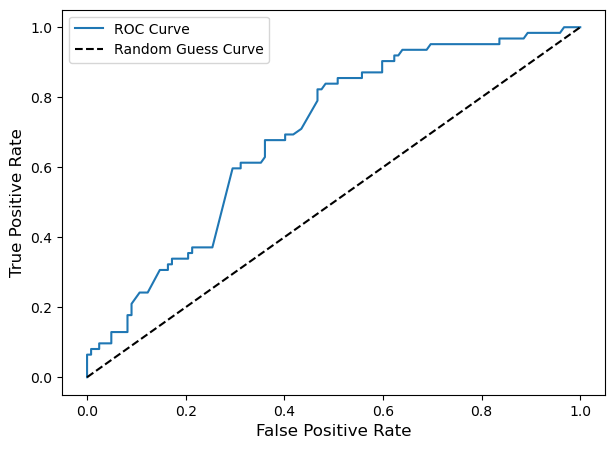

In [334]:
# Plot False Positive vs. True Positive rates parametrized by different cutoff value
fprs, tprs, cutoffs = roc_curve(y_train, log_reg.predict_proba(X_train['total_carb'].values.reshape(-1,1))[:,1])

plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [335]:
# This identifies the cutoff for which the sum of sensitivity + specificity is largest
np.argmax(tprs - fprs)

42

In [336]:
## Sensitivity and Specificity
cutoff = .42
y_train_pred = 1*(y_prob >= cutoff)

TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training sensitivity (true positive rate) is",
         np.round(TP/(TP+FN),4))

## TNR
print("The training specificity (true negative rate) is",
         np.round(TN/(TN+FP),4))

The training sensitivity (true positive rate) is 0.3065
The training specificity (true negative rate) is 0.8443


## Model 1: predict high glucose by total carbs and glycemic index

In [337]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','gi']].values,
            y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty=None)

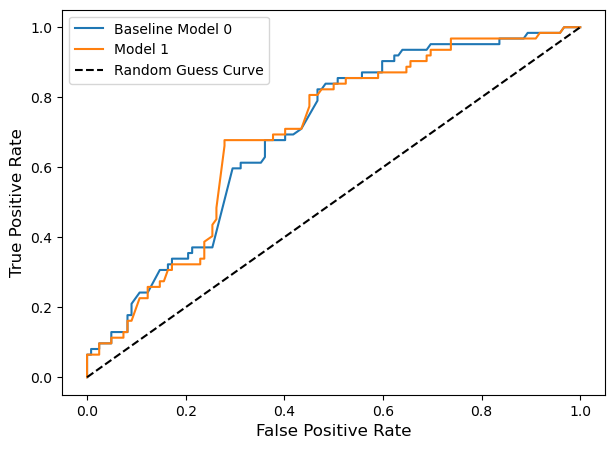

In [338]:
# Plot False Positive vs. True Positive rates parametrized by different cutoff values
## Compare Model 1 (total carb + gi), Model 0 (total carb), Random Guess Model
y_prob = log_reg.predict_proba(X_train[['total_carb','gi']].values)[:,1]
fprs_1, tprs_1, cutoffs_1 = roc_curve(y_train, y_prob)

plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [339]:
## Sensitivity and Specificity
cutoff = .35
y_train_pred = 1*(y_prob >= cutoff)

TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training sensitivity (true positive rate) is",
         np.round(TP/(TP+FN),4))

## TNR
print("The training specificity (true negative rate) is",
         np.round(TN/(TN+FP),4))

The training sensitivity (true positive rate) is 0.6774
The training specificity (true negative rate) is 0.7131


## Model 2: predict high glucose by total carbs, sugar, protein, total fat

In [340]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','sugar','protein','total_fat']].values,
            y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty=None)

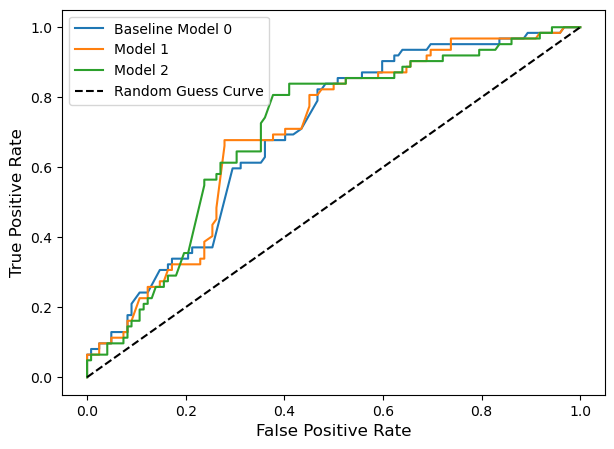

In [341]:
# Plot False Positive vs. True Positive rates parametrized by different cutoff values
## Compare Model 1 (total carb + gi), Model 0 (total carb), Random Guess Model
y_prob = log_reg.predict_proba(X_train[['total_carb','sugar','protein','total_fat']].values)[:,1]
fprs_2, tprs_2, cutoffs_2 = roc_curve(y_train, y_prob)

plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot(fprs_2, tprs_2, label="Model 2")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [342]:
## Sensitivity and Specificity
cutoff = .3
y_train_pred = 1*(y_prob >= cutoff)

TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training sensitivity (true positive rate) is",
         np.round(TP/(TP+FN),4))

## TNR
print("The training specificity (true negative rate) is",
         np.round(TN/(TN+FP),4))

The training sensitivity (true positive rate) is 0.8065
The training specificity (true negative rate) is 0.5984


## Model 3: predict high glucose by total carbs, glycemic index, and starting glucose value

In [343]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','gi','start_glucose']].values,
            y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty=None)

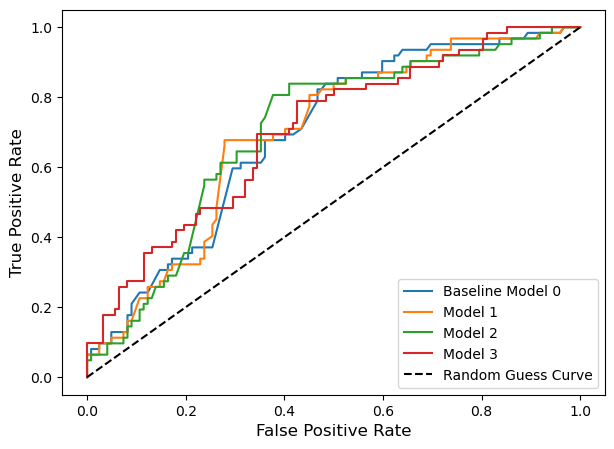

In [344]:
# Plot False Positive vs. True Positive rates parametrized by different cutoff values
## Compare Models 0-3 and Random Guess
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','start_glucose']].values)[:,1]
fprs_3, tprs_3, cutoffs_3 = roc_curve(y_train, y_prob)

plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot(fprs_2, tprs_2, label="Model 2")
plt.plot(fprs_3, tprs_3, label="Model 3")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [345]:
## Note: for a high glucose threshold of 95th percentile, this model does not do any better
## than previous models. However, when setting the threshold for high glucose at the 90th percentile,
## this model provides a subtantial improvement. To see this, go back to the Data Import and Pre-processing
## section, re-set the high glucose threshold at 90, and re-run the code.

## Sensitivity and Specificity
cutoff = .44
y_train_pred = 1*(y_prob >= cutoff)

TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training sensitivity (true positive rate) is",
         np.round(TP/(TP+FN),4))

## TNR
print("The training specificity (true negative rate) is",
         np.round(TN/(TN+FP),4))

The training sensitivity (true positive rate) is 0.371
The training specificity (true negative rate) is 0.8525
